<a href="https://colab.research.google.com/github//pylabel-project/samples/blob/main/pylabel2albumentations.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 
# Using PyLabel and Albumentations
Based on https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/example_bboxes.ipynb

In [ ]:
%pip install pylabel 
%pip install -q -U albumentations

In [ ]:
%pip uninstall opencv-python-headless
%pip install opencv-python-headless==4.1.2.30

In [115]:
#Setup dependencies 
%matplotlib inline

from pylabel import importer
import albumentations as A

import os, zipfile
from pathlib import PurePath
from os.path import exists
from decimal import *

import copy
import cv2
from matplotlib import pyplot as plt


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Download Custom Dataset 
For this demonstration we will download 100 images from the <a href="https://github.com/pylabel-project/datasets_models#squirrels-and-nuts">squirrels and nuts dataset with annotations in YOLOv5 format.</a> PyLabel can also import datasets in COCO and PASCAL VOC format. 

In [109]:
%%capture
os.makedirs("data/", exist_ok=True)
!wget "https://github.com/pylabel-project/datasets_models/blob/main/squirrelsandnuts/squirrelsandnuts_train.zip?raw=true" -O data/squirrelsandnuts_train.zip
with zipfile.ZipFile("data/squirrelsandnuts_train.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")

In [110]:
#Import annotations as a PyLabel dataset
dataset = importer.ImportYoloV5(path="data/squirrelsandnuts_train/labels/train",
        path_to_images="../../images/train", 
        img_ext="jpeg",
        cat_names=['Squirrel','Nut']
    )
dataset.df

,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,...,ann_segmentation,ann_iscrowd,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,
0,../../images/train,2021-07-03T06-30-10-frame_0001.jpeg,NaN,0,960,540,3,NaN,255.024,170.991,...,NaN,NaN,NaN,NaN,NaN,0,Squirrel,NaN,NaN,1
1,../../images/train,2021-07-03T06-47-39-frame_0004.jpeg,NaN,1,960,540,3,NaN,650.016,447.984,...,NaN,NaN,NaN,NaN,NaN,1,Nut,NaN,NaN,1
2,../../images/train,2021-07-03T06-47-39-frame_0004.jpeg,NaN,1,960,540,3,NaN,690.480,422.010,...,NaN,NaN,NaN,NaN,NaN,1,Nut,NaN,NaN,1
3,../../images/train,2021-07-03T06-47-39-frame_0004.jpeg,NaN,1,960,540,3,NaN,740.016,412.479,...,NaN,NaN,NaN,NaN,NaN,1,Nut,NaN,NaN,1
4,../../images/train,2021-07-03T06-47-39-frame_0004.jpeg,NaN,1,960,540,3,NaN,806.016,404.973,...,NaN,NaN,NaN,NaN,NaN,1,Nut,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,../../images/train,2021-07-03T07-55-47-frame_0007.jpeg,NaN,96,960,540,3,NaN,35.520,116.991,...,NaN,NaN,NaN,NaN,NaN,0,Squirrel,NaN,NaN,1
219,../../images/train,2021-07-03T07-55-47-frame_0006.jpeg,NaN,97,960,540,3,NaN,37.536,86.508,...,NaN,NaN,NaN,NaN,NaN,0,Squirrel,NaN,NaN,1
220,../../images/train,2021-07-03T06-30-24-frame_0000.jpeg,NaN,98,960,540,3,NaN,18.480,233.010,...,NaN,NaN,NaN,NaN,NaN,0,Squirrel,NaN,NaN,1


## Use albumentations to augment images and bounding boxes

In [111]:
#Iterate the rows for each image in the dataframe
for img_filename, img_df in dataset.df.groupby('img_filename'):
    img_path = PurePath(dataset.path_to_annotations, str(img_df.iloc[0].img_folder), img_filename)
    img_path_str = str(img_path)
    assert exists(img_path_str), f"File does not exist: {img_path_str}"

    #Create a list of bounding boxes for each image in the dataset  
    bboxes = []
    for index, row in img_df.iterrows():
        #arranges labels in this format [x_min, y_min, x_max, y_max, label]

        #Get bounding box coordinates and make sure that they don't extend beyond image boundary
        xmin = Decimal(row.ann_bbox_xmin).max(0)
        ymin = Decimal(row.ann_bbox_ymin).max(0)
        xmax = Decimal(row.ann_bbox_xmax).min(row.img_width)
        ymax = Decimal(row.ann_bbox_ymax).min(row.img_height)
        label = row.cat_name
        
        bboxes.append([xmin, ymin, xmax, ymax, label])

    transform = A.Compose(
        [A.HorizontalFlip(p=0.5)],
        bbox_params=A.BboxParams(format='pascal_voc'),
    )

    #prepare the annotations to be transformed
    image = cv2.imread(img_path_str)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transformed = transform(image=image, bboxes=bboxes)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']

    #Save the augmented image, append _augmented to the name of the new image
    augmented_file_name = img_path.stem + "_augmented" + img_path.suffix
    augmented_path_str = str(PurePath(img_path.parent, augmented_file_name) )
    cv2.imwrite(augmented_path_str, transformed_image)

    #Add the annotations to the PyLabel dataframe 
    
    new_img_id = dataset.df.img_id.max() + 1

    for bbox in transformed_bboxes:
        xmin, ymin, xmax, ymax, label = bbox
        
        new_row = copy.deepcopy(img_df.iloc[0])
        new_row.img_filename = augmented_file_name
        new_row.img_id = new_img_id
        new_row.ann_bbox_xmin = xmin
        new_row.ann_bbox_ymin = ymin
        new_row.ann_bbox_xmax = xmax
        new_row.ann_bbox_ymax = ymax
        new_row.cat_name = label
        dataset.df = dataset.df.append(new_row)

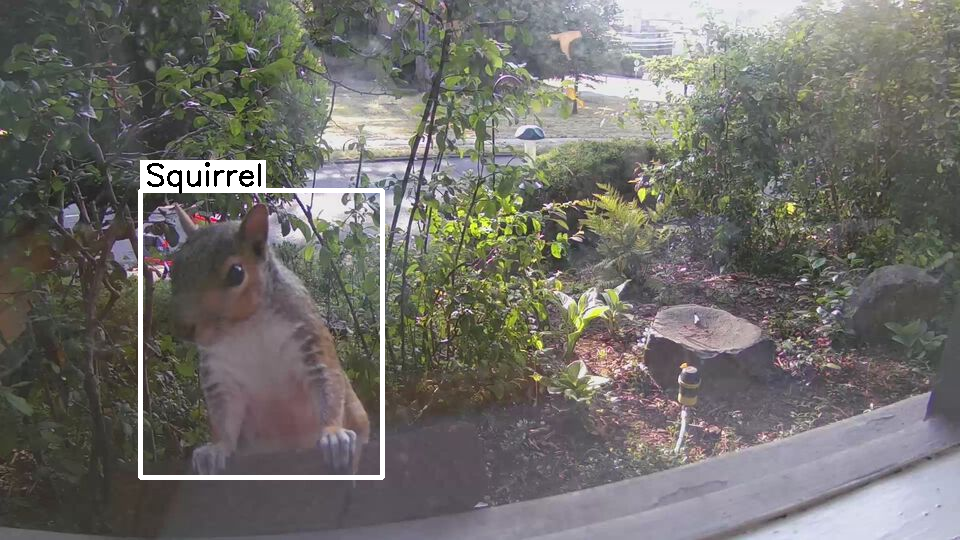

In [113]:
dataset.visualize.ShowBoundingBoxes("2021-07-03T07-55-20-frame_0001.jpeg")

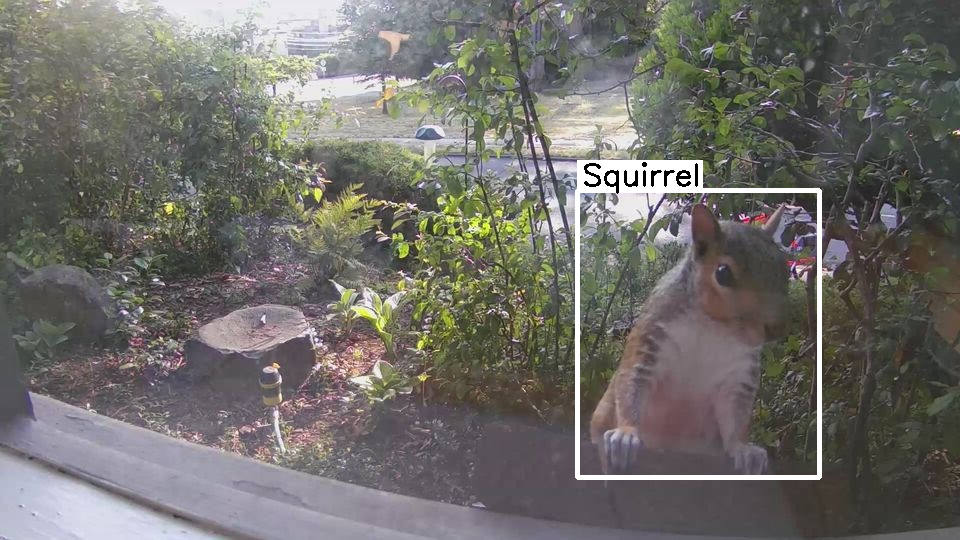

In [114]:
dataset.visualize.ShowBoundingBoxes("2021-07-03T07-55-20-frame_0001_augmented.jpeg")